## Gait Video Study
### SHAP-based feature importance for Task generalization framework
For local interpretation explanations, see https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html

For installation, run:
* !pip install --upgrade setuptools
* !conda install -c conda-forge shap

For running this code, we would need 'config path' for the best task gen model containing the "saved_model_path" as the best task gen model's directory 

In [2]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import gait_data_loader
reload(gait_data_loader)
from ml_utils import task_gen_DLtrainer, DLutils, CNN1d_model, TCN_model, LSTM_model, GRU_model, RNN_model, MULTISCALE_RESNET_model, RESNET_model
reload(task_gen_DLtrainer)
reload(DLutils)
reload(CNN1d_model)
reload(TCN_model)
reload(LSTM_model)
reload(GRU_model)
reload(RNN_model)
reload(RESNET_model)
reload(MULTISCALE_RESNET_model)
from ml_utils.DLutils import set_random_seed
from ml_utils.task_gen_DLtrainer import GaitTrainer
from ml_utils.CNN1d_model import CNN1D
from ml_utils.TCN_model import TCN
from ml_utils.LSTM_model import LSTM
from ml_utils.GRU_model import GRU
from ml_utils.RNN_model import RNN
from ml_utils.MULTISCALE_RESNET_model import MSResNet
from ml_utils.RESNET_model import ResNet
import shap

In [3]:
#Config path for the best task gen model containing the "saved_model_path" as the 
#best model's directory 
config_path = ".\config_files\config_template_task_gen_shap_cnn.json"

#Set up vars for parsing
hyperparameter_grid = {}
parameter_dict = {}

#Load config
with open(config_path) as f: 
    config_data = f.read()

config = json.loads(config_data)

#Parse through imported dictionary
for key, value in config.items():
    if 'param_' in key:
        pkey = key.replace("param_", "")
        if 'optimizer' in pkey:
            op = []
            for optim_string in value:
                op.append(optims[optim_string])
            hyperparameter_grid[pkey] = op
        else:
            hyperparameter_grid[pkey] = value
    else:
        parameter_dict[key] = value      

In [4]:
trainer = GaitTrainer(parameter_dict, hyperparameter_grid, config_path)
#Initial setup for SHAP for Task Generalization 
trainer.task_gen_shap_initial_setup()

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training frame count mean:  tensor(41.3294, dtype=torch.float64)
Training frame count standard deviation:  tensor(9.9662, dtype=torch.float64)
Normalized training data's mean: tensor(-3.3395e-16, dtype=torch.float64)
Normalized training data's standard deviation: tensor(1.0000, dtype=torch.float64)
save path:  C:\Users\Rachneet Kaur\Box\Gait Video Project\DLResults\WtoWT/CNN1D\cnn_try_task_gen_2021_05_26-20_10_54_660581/


In [5]:
trainer.best_model.module, trainer.X_sl_test, trainer.Y_sl_test

(CNN1D(
   (pos_encoding_layer): PositionalEncoder()
   (cnn_network): Sequential(
     (0): ConvBlock(
       (conv1): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
       (batch_norm_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
       (dropout_layer): Dropout(p=0.3, inplace=False)
       (convblock_net): Sequential(
         (0): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
         (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU()
         (3): Dropout(p=0.3, inplace=False)
       )
     )
     (1): ConvBlock(
       (conv1): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
       (relu): ReLU()
       (dropout_layer): Dropout(p=0, inplace=False)
       (convblock_net): Sequential(
         (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
         (1): ReLU()
         (2): Dropout(p=0, inplace=False)
       )
     )
     (2): ConvBlock(
       (conv1): Conv1d(12

In [6]:
#Rearranging the training data to fit the SHAP requirements 
train_body_coords = [trainer.X_sl_train[index]['body_coords'] for index in range(len(trainer.X_sl_train))]
train_body_coords = torch.stack(train_body_coords) 

train_frame_count = [trainer.X_sl_train[index]['frame_count'] for index in range(len(trainer.X_sl_train))]
train_frame_count = torch.stack(train_frame_count)

train_data = [train_body_coords, train_frame_count]
print ('Train data stats: ', len(train_data), train_data[0].shape, train_data[1].shape)

#SHAP Deep Explainer for CNN
explainer = shap.DeepExplainer(trainer.best_model.module, train_data)

Train data stats:  2 torch.Size([1008, 20, 36]) torch.Size([1008])


In [7]:
#Rearranging the testing data to fit the SHAP requirements 
test_body_coords = [trainer.X_sl_test[index]['body_coords'] for index in range(len(trainer.X_sl_test))]
test_body_coords = torch.stack(test_body_coords)

test_frame_count = [trainer.X_sl_test[index]['frame_count'] for index in range(len(trainer.X_sl_test))]
test_frame_count = torch.stack(test_frame_count)

test_data = [test_body_coords, test_frame_count]
print ('Test data stats: ', len(test_data), test_data[0].shape, test_data[1].shape)

#Running the SHAP explainer for test set
shap_values = explainer.shap_values(test_data)

Test data stats:  2 torch.Size([1016, 20, 36]) torch.Size([1016])


In [8]:
#Stats for the SHAP values 
print (len(shap_values)) #Since we have 3 classes 
print (len(shap_values[0]), len(shap_values[1]), len(shap_values[2])) 
#Since we have 2 types of inputs, namely body coordinates and frame count 
print (shap_values[0][0].shape) #Since body coords is 20*36

3
2 2 2
(1016, 20, 36)


In [9]:
#Postprocessing the SHAP values to reshape to num_classes x num_samples x num_features i.e. across 
#the body coords, we would need to average the 20 SHAP values for 20 time steps to one SHAP value 
#per sample and feature. 
classes = [0, 1, 2]
shaps_feature_wise = []
for class_index in classes:
    #For body coords, averaging across the 20 time steps to have one SHAP value 
    #for each instance, feature pair
    shap_body_coords = shap_values[class_index][0].mean(axis = 1)
    #For frame count
    shap_frame_count = shap_values[class_index][1].reshape(-1, 1)
    shap_feature_wise = np.concatenate((shap_body_coords, shap_frame_count), axis = 1)
    shaps_feature_wise.append(shap_feature_wise) 

In [10]:
#As the SHAP values for body coords are now one feature per sample, and thus we need to average 
#the original test set body coords values as well to have one feature per sample 
Xtest_feature_wise = np.concatenate((test_data[0].mean(axis = 1), test_data[1].reshape(-1, 1)), axis = 1)
order = ['Right Hip', 'Right Knee', 'Right Ankle', 'Left Hip', 'Left Knee', 'Left Ankle', 'Left Big Toe', 'Left Little Toe', \
         'Left Heel', 'Right Big Toe', 'Right Little Toe', 'Right Heel']
feature_names = [o + '-'+ y for o in order for y in ['x', 'y', 'z']] + ['Frame Count']
Xtest_feature_wise_df = pd.DataFrame(Xtest_feature_wise, columns= feature_names)

print (shaps_feature_wise[0].shape, Xtest_feature_wise_df.shape)

(1016, 37) (1016, 37)


## SHAP Vizualizations 

In [11]:
# init the JS visualization code
shap.initjs()

### Global feature importance Bar Plot 
### This has all 3 classes included in a single plot 

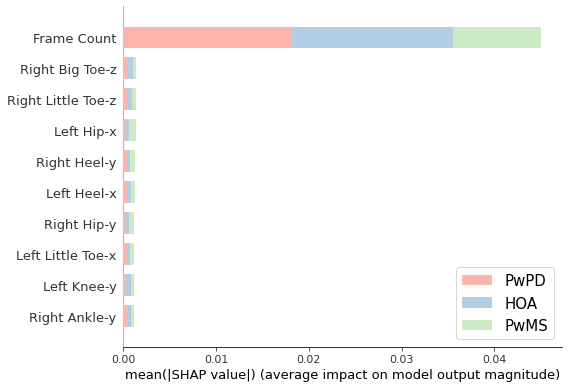

In [12]:
#Global feature importance Bar Plot 
#This has all 3 classes included in a single plot 
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise, features = Xtest_feature_wise_df, plot_type='bar', \
                  class_names= ['HOA', 'PwMS', 'PwPD'], max_display=10, show=False,  color=plt.get_cmap("Pastel1"))
f = plt.gcf()
plt.tight_layout()
plt.legend(fontsize = 15)
#All plots are saved to SHAPResults directory
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_bar.png', dpi = 350)

### Global feature importance Beeswarm plot
### We need 3 different plots for 3 classes in this case 

For HOA


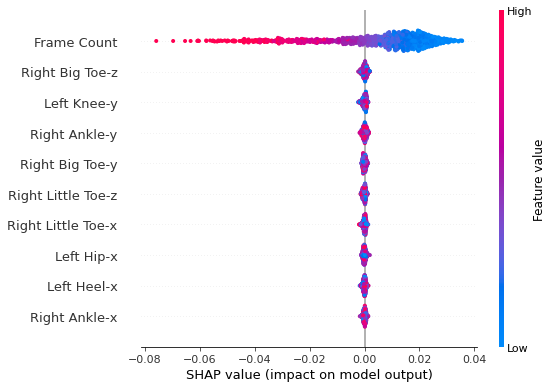

In [13]:
#Global feature importance Beeswarm plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_HOA.png', dpi = 350)

For PwMS


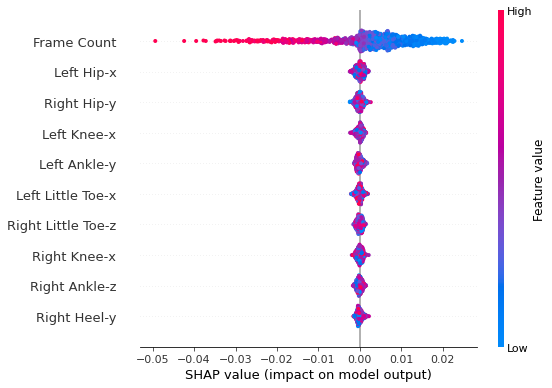

In [14]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwMS.png', dpi = 350)

For PwPD


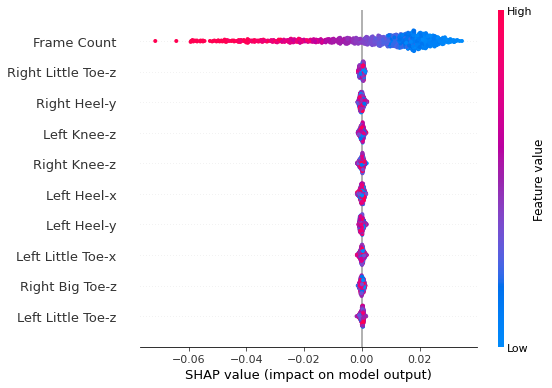

In [15]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwPD.png', dpi = 350)

### Global feature importance Violin plot
### We need 3 different plots for 3 classes in this case 

For HOA


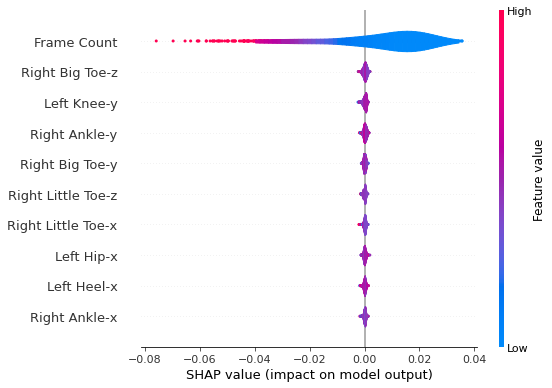

In [16]:
#Global feature importance Violin plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_HOA.png', dpi = 350)

For PwMS


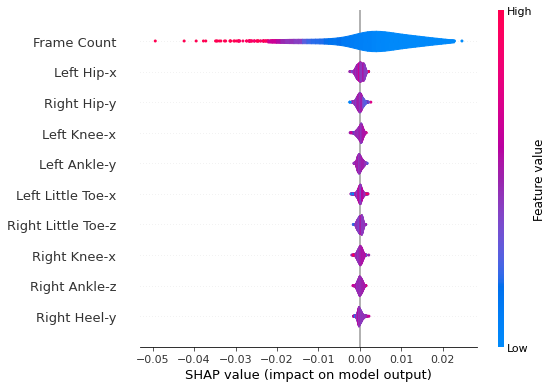

In [17]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwMS.png', dpi = 350)

For PwPD


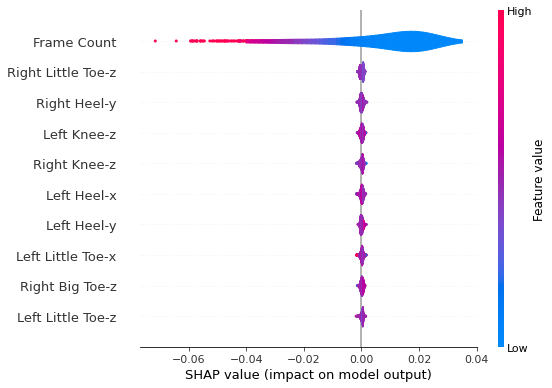

In [18]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwPD.png', dpi = 350)

### Local feature importance force plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance 

In [21]:
#Force plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
classes = [0, 1, 2]
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
out_names_ = ['HOA', 'PwMS', 'PwPD']
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

for class_to_explain in classes:
# plot the explanation of the first prediction
    force_ = shap.force_plot(
        base_value=explainer.expected_value[class_to_explain],
        shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
        features=Xtest_feature_wise_df.iloc[instance_to_explain],
        feature_names=Xtest_feature_wise_df.columns,
        link="identity",
        out_names=out_names_[class_to_explain]
    )
    #This plot doesn't display but is directly saved at the specified path 
    shap.save_html('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
              '/shap_local_force_instance' + str(instance_to_explain) + '_' + out_names_[class_to_explain] + '.htm', force_)

#Display all features and SHAP values
#The table below the plot is the full list of features and their 
#SHAP additive weights.
#Display all features and SHAP values for all 3 classes 
df1=pd.DataFrame(data=shaps_feature_wise[0][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[0]).transpose().sort_values(by=0, ascending=True)
df2=pd.DataFrame(data=shaps_feature_wise[1][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[1]).transpose().sort_values(by=1, ascending=True)
df3=pd.DataFrame(data=shaps_feature_wise[2][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[2]).transpose().sort_values(by=2, ascending=True)
df=pd.concat([df1,df2,df3], axis = 1)
df.columns = ['HOA', 'PwMS', 'PwPD']
display(df.transpose())

Expected values:  [-0.21485898  0.08578876 -0.3413532 ]
True label:  tensor(0)


,Left Knee-x,Left Hip-x,Left Big Toe-z,Left Hip-y,Right Ankle-y,Right Big Toe-z,Right Hip-x,Right Big Toe-y,Right Big Toe-x,Left Knee-z,...,Left Heel-z,Left Big Toe-y,Right Ankle-x,Right Little Toe-x,Left Ankle-y,Right Little Toe-z,Left Knee-y,Left Ankle-x,Left Little Toe-z,Frame Count
HOA,-0.000580,-0.000537,-0.000299,-0.000268,-0.000263,-0.000202,-0.000109,-0.000089,-0.000053,-0.000037,...,0.000226,0.000236,0.000251,0.000263,0.000333,0.000366,0.000372,0.000378,0.000379,0.008701
PwMS,0.001157,0.000728,0.000062,0.000090,0.000150,0.000300,0.000324,0.000240,-0.000009,-0.000104,...,0.000753,-0.000084,0.000142,-0.000259,-0.000308,0.000488,-0.000146,-0.000553,-0.000950,0.000843
PwPD,0.000178,-0.000095,0.000017,0.000067,-0.000113,0.000231,-0.000108,0.000052,0.000212,0.000387,...,-0.000370,-0.000086,0.000030,0.000076,-0.000120,0.000617,0.000153,0.000153,-0.000591,0.008814


### Local feature importance decision plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance only

Expected values:  [-0.21485898  0.08578876 -0.3413532 ]
True label:  tensor(0)


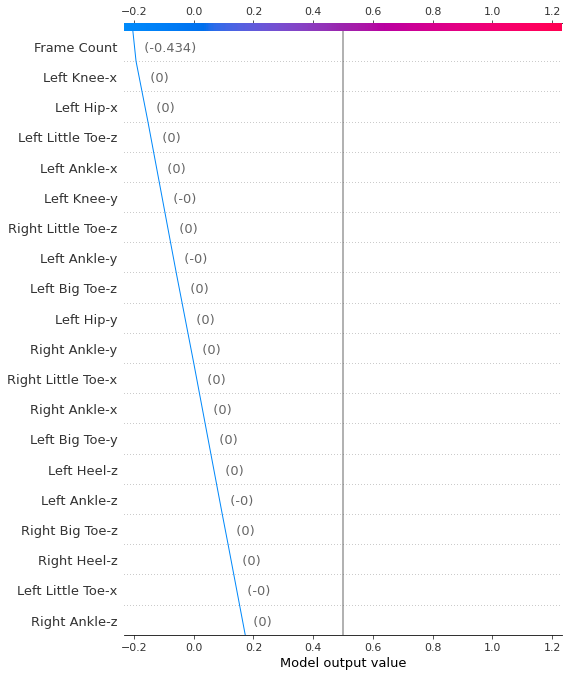

In [20]:
##Decision plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# We provide new_base_value as the cutoff probability for the classification mode
# This is done to increase the interpretability of the plot 
new_base_value=0.5

# plot the explanation of the first prediction
shap.decision_plot(
    base_value=explainer.expected_value[class_to_explain],
    shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
    features=Xtest_feature_wise_df.iloc[instance_to_explain],
    feature_names=Xtest_feature_wise_df.columns.to_list(),
    link="identity",
    new_base_value=0.5,
    show = False
)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
          '/shap_local_decision_instance' + str(instance_to_explain) + '_' + out_name + '.png', dpi = 350)